In [1]:
import pandas as pd
import re
import math
from matplotlib import pyplot as plt
from collections import Counter
from scipy.stats import ttest_ind, ttest_rel
from statsmodels.regression.linear_model import OLS

In [2]:
# Function to convert product_size to OZ
def product_size_oz(val):
    nums = re.compile("([0-9]+([.][0-9]+)?)")
    num_frac = re.compile("[0-9]+ [0-9]+[/][0-9]+")
    if type(val) is float and math.isnan(val):
        value = 0
    elif "LB" in val:
        if "OZ" in val:
            [(lb,_), (oz,_)] = nums.findall(val)
            value = 16*float(lb) + float(oz)
        else:
            value = 16*float(nums.search(val).group(0))
    elif "OZ" in val or "OUNCE" in val:
        if num_frac.search(val):
            match_val = num_frac.search(val).group(0)
            (whole, frac) = match_val.split(" ")
            (num, dem) = frac.split("/")
            value = int(whole)+ (int(num)/int(dem))
        elif nums.search(val):
            value = float(nums.search(val).group(0))
        else:
            value = 0
    elif "GAL" in val:
        value = 128.0
    else:
        value = 0
    return value

In [3]:
def fill_product_size(row):
    if (type(row["product_size"]) is float and math.isnan(row["product_size"])) or\
        (("OZ" not in row["product_size"]) and\
        ("LB" not in row["product_size"]) and\
        ("OUNCE" not in row["product_size"]) and\
        ("GAL" not in row["product_size"])):
        res = re.search("[0-9]+([.][0-9]+)? OZ", row["product_description"])
        if res:
            return res.group(0)
        else:
            return row["product_size"]
    else:
        return row["product_size"]

In [4]:
def sweet_or_savoury(val):
    if "pasta" in val:
        return "Savoury"
    else:
        return "Sweet"

In [5]:
def purchase_customer_segment(row):
    if row["max_week"] < 52:
        return "Lost Customer"
    elif row["num_visits"] == 1 and row["max_week"] < 100:
        return "One and Done"
    elif row["num_visits"] == 1:
        return "New Customer"
    elif row["num_weeks"] > 52:
        return "Frequent Flyer"
    elif (row["total_units"] / row["num_visits"]) > 5:
        return "Bulk Buyer"
    elif (row["total_sales"] / row["total_units"]) > 5:
        return "High Roller"
    elif row["num_stores"] == 1:
        return "Store Loyal"
    else:
        return "Average Joe"

In [6]:
def product_customer_segment(row):
    if row["num_products"] == 1 and row["num_visits"] > 1:
        return "Product Loyal"
    elif row["num_brand"] == 1 and row["num_visits"] > 1:
        return "Brand Loyal"
    elif row["num_commodity"] == 1 and row["num_visits"] > 1:
        return "Single Type"
    elif row["sweet_savoury_mix"] != "Both":
        return "Single Taste"
    elif row["num_visits"] == 1:
        return "Too New To Tell"
    else:
        return "Limited Loyalty"

In [7]:
# Load Data
trnx = pd.read_csv("data/transactions.csv", na_values = [" ", ""])
product = pd.read_csv("data/product_lookup.csv", na_values = [" ", ""])
store = pd.read_csv("data/store_lookup.csv", na_values = [" ", ""])
display = pd.read_csv("data/causal_lookup.csv", na_values = [" ", ""])

In [8]:
# Data Transformation & Feature Engineering

## Fill any missing product sizes where possible (43596 missing initially)
product["product_size_fix"] = product.apply(func=fill_product_size, axis=1)

## Convert Product Size to OZ
product["product_size_oz"] = product["product_size_fix"].apply(func=product_size_oz)
    
## Add Sweet or Savoury Column
product["sweet_savoury"] = product["commodity"].apply(sweet_or_savoury)

## Change sales to float
trnx["sales"] = trnx["Dollar Sales"].str.replace("$","").apply(func=float)

## Change Trnx Date Time to a python datetime
trnx["Transaction Date Time"] = pd.to_datetime(trnx["Transaction Date Time"],format="%d/%m/%Y %I:%M:%S %p")

## Add price variable
trnx["price"] = trnx.apply(lambda row: row["sales"] / row["Units"], axis=1)

## Add "Year" Column
trnx["Year"] = trnx["Week"].apply(lambda x: (x-1) // 52)

## Add "WeekOfYear" Column
trnx["WeekOfYear"] = trnx["Week"].apply(lambda x: (x-1) % 52)

# Prep Transactions

## Join store and product data
denorm_trnx = trnx.merge(product, 
                         left_on= "Upc", 
                         right_on = "upc", 
                         how= "left").drop("upc", axis=1)
denorm_trnx = denorm_trnx.merge(store, 
                                left_on= "Store", 
                                right_on = "store", 
                                how= "left").drop("store", axis=1)
denorm_trnx = denorm_trnx.merge(display, 
                                left_on= ["Store","Upc","Week","Geography"], 
                                right_on= ["store","upc","week","geography"], 
                                how= "left").drop(["store","upc","week","geography"], axis=1)

## Fill NaN values for display data
denorm_trnx["feature_desc"] = denorm_trnx["feature_desc"].fillna("Not on Feature")
denorm_trnx["display_desc"] = denorm_trnx["display_desc"].fillna("Not on Display")


## Check for products and stores not in the lookup tables
null_count = 0
for column, value in denorm_trnx.isnull().sum().items():
    if value > 0:
        print(f"{column} has {value} missing values!")
        null_count += 1
    else:
        continue

if null_count == 0:
    print("All columns complete!")

product_size has 43596 missing values!
product_size_fix has 43596 missing values!


In [9]:
# Construct Customer Profile (or load from Disk)
try:
    customer_profile = pd.read_csv("data/customer_profile.csv", index_col="Household")
    print("Read Profile from disk")
except Exception as e:
    # Create Customer Profile Table
    print("Constructing customer profile (this will take a few minutes...)")
    customer_profile = denorm_trnx.groupby("Household").agg({"sales": ["sum"], 
                                                              "Units": ["sum"], 
                                                              "Upc": ["nunique"],
                                                              "Week": ["nunique", "max", "min"],
                                                              "Basket ID": ["nunique"],
                                                              "Coupon": ["sum", "mean"],
                                                              "commodity": ["nunique", pd.Series.mode],
                                                              "brand": ["nunique", pd.Series.mode],
                                                              "sweet_savoury": ["nunique", "min"],
                                                              "Store": ["nunique", pd.Series.mode],
                                                              "Transaction Date Time": ["max"]})

    # Rename columns to remove multilevel
    customer_profile.columns = ["total_sales", 
                                "total_units", 
                                "num_products", 
                                "num_weeks", 
                                "max_week",
                                "min_week",
                                "num_visits", 
                                "total_coupons",
                                "coupon_pct",
                                "num_commodity",
                                "fave_commodity",
                                "num_brand",
                                "fave_brand",
                                "num_sweet_savoury",
                                "sweet_or_savoury",
                                "num_stores",
                                "fave_store",
                                "last_trnx"]

    # Create profile attributes using only the latest year
    customer_profile_this_year = denorm_trnx[denorm_trnx["Week"] > 52].groupby("Household").agg({"sales": ["sum"], 
                                                                                                 "Units": ["sum"],
                                                                                                 "Week": ["nunique"],
                                                                                                 "Basket ID": ["nunique"]})

    # Rename columns to remove multilevel
    customer_profile_this_year.columns = ["total_sales_y2", 
                                          "total_units_y2", 
                                          "num_weeks_y2", 
                                          "num_visits_y2"]


    # Create new column to class a customer as "sweet" or "savoury"
    customer_profile["sweet_savoury_mix"] = customer_profile.apply(lambda row: "Both" if row["num_sweet_savoury"] == 2 else row["sweet_or_savoury"], axis= 1)

    # Remove uncessary columns
    customer_profile = customer_profile.drop(["num_sweet_savoury", "sweet_or_savoury"], axis=1)

    # Join latest year attributes
    customer_profile = customer_profile.join(customer_profile_this_year, how="left")

    # Save profile to disk
    customer_profile.to_csv("data/customer_profile.csv")

# Show some rows
print(customer_profile.head())

Read Profile from disk
           total_sales  total_units  num_products  num_weeks  max_week  \
Household                                                                
1                23.00           17            16         11       104   
2               343.74          155            62         65       104   
3                 5.28            2             2          1        46   
4                 2.85            3             3          2        84   
5                 9.83            6             4          3        38   

           min_week  num_visits  total_coupons  coupon_pct  num_commodity  \
Household                                                                   
1                 5          11              0    0.000000              4   
2                 4          88              2    0.014599              4   
3                46           1              0    0.000000              2   
4                60           2              0    0.000000              2

In [10]:
# Create Customer Segments

customer_profile["purchase_segment"] = customer_profile.apply(purchase_customer_segment, axis = 1)
customer_profile["product_segment"] = customer_profile.apply(product_customer_segment, axis = 1)
customer_profile["recency"] = customer_profile["max_week"].rank(pct=True).apply(lambda x: 1 if x > 0.66 else 2 if x > 0.33 else 3)
customer_profile["frequency"] = customer_profile["num_visits_y2"].fillna(0).rank(pct=True).apply(lambda x: 1 if x > 0.66 else 2 if x > 0.33 else 3)
customer_profile["monetary"] = customer_profile["total_sales_y2"].fillna(0).rank(pct=True).apply(lambda x: 1 if x > 0.66 else 2 if x > 0.33 else 3)

In [12]:
# Summary Stats

print(f"Total unique customers: {customer_profile.shape[0]}")
print(f"Active Customers: {customer_profile[customer_profile['max_week'] > 52].shape[0]}")
print(customer_profile["num_visits"].apply(lambda x: "Single Visit" if x == 1 else "Multiple Visits").value_counts())
print(f"Average Basket Size: {float(denorm_trnx.groupby('Basket ID')['Upc'].count().mean())}")
print(customer_profile["sweet_savoury_mix"].value_counts())
print(denorm_trnx.groupby("commodity").agg({"Units":"sum"}))
print(customer_profile["total_coupons"].apply(lambda x: 0 if x == 0 else 1).value_counts())
print(customer_profile.groupby("purchase_segment").agg({"max_week":"count",
                                                        "total_sales":"mean", 
                                                        "total_units": "mean",
                                                        "num_visits": "mean"}))
print(customer_profile.groupby("product_segment").agg({"max_week":"count",
                                                        "total_sales":"mean", 
                                                        "total_units": "mean",
                                                        "num_visits": "mean"}))
print(customer_profile[((customer_profile["recency"] == 1) & (customer_profile["frequency"] == 1) & (customer_profile["monetary"] == 1)) |
                      ((customer_profile["recency"] == 1) & (customer_profile["frequency"] == 3) & (customer_profile["monetary"] == 1)) |
                      ((customer_profile["recency"] == 1) & (customer_profile["frequency"] == 1) & (customer_profile["monetary"] == 3)) |
                      ((customer_profile["recency"] == 3) & (customer_profile["frequency"] == 1) & (customer_profile["monetary"] == 1))].groupby(["recency","frequency","monetary"]).agg({"max_week":"count",
                                                                                                                                                                                                "total_sales":"mean", 
                                                                                                                                                                                                "total_units": "mean",
                                                                                                                                                                                                "num_visits": "mean"}))
print(customer_profile.groupby(["recency","frequency","monetary"]).agg({"max_week":"count",
                                                                        "total_sales":"mean", 
                                                                        "total_units": "mean",
                                                                        "num_visits": "mean"}))



Total unique customers: 510027
Active Customers: 383547
Multiple Visits    356637
Single Visit       153390
Name: num_visits, dtype: int64
Average Basket Size: 1.5672901133143706
Both       234426
Savoury    226630
Sweet       48971
Name: sweet_savoury_mix, dtype: int64
                 Units
commodity             
pancake mixes   300646
pasta          2880837
pasta sauce    2313168
syrups          724976
0    467999
1     42028
Name: total_coupons, dtype: int64
                  max_week  total_sales  total_units  num_visits
purchase_segment                                                
Average Joe         159124    31.107752    21.160950   11.230958
Bulk Buyer            1992    43.619603    36.787651    5.617972
Frequent Flyer        1356   217.328606   146.067109   72.753687
High Roller             55    34.377273     6.345455    4.781818
Lost Customer       123637     5.865524     3.914297    2.113324
New Customer         11107     2.872619     1.954713    1.000000
One and Done 

In [33]:
print(f"Customers in year 1: {customer_profile[customer_profile['min_week'] < 53].shape[0]}")
print(f"Customers in year 1: {customer_profile[customer_profile['max_week'] < 53].shape[0]}")
print(f"New Customers in year 2: {customer_profile[customer_profile['min_week'] > 52].shape[0]}")
print(f"New Customers in year 2: {customer_profile[customer_profile['max_week'] > 52].shape[0]}")
print(denorm_trnx.groupby(["Household","Year"]).agg({"Coupon": "max",
                                                    "sales": "sum",
                                                    "Units": "sum",
                                                    "Basket ID": "count"}).reset_index().pivot(index="Household",columns="Year").mean())
print(denorm_trnx.groupby(["Basket ID","Year"]).agg({"Upc": "count"}).reset_index().pivot(index="Basket ID",columns="Year").mean())

Customers in year 1: 364141
Customers in year 1: 126480
New Customers in year 2: 145886
New Customers in year 2: 383547
           Year
Coupon     0        0.071313
           1        0.064667
sales      0       12.215737
           1       12.206663
Units      0        8.140858
           1        8.487114
Basket ID  0        6.873370
           1        7.026010
dtype: float64
     Year
Upc  0       1.558136
     1       1.575889
dtype: float64


total_sales


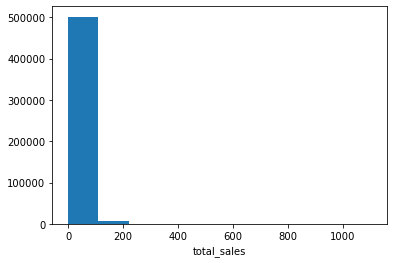

total_units


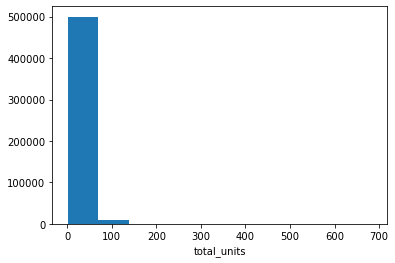

num_products


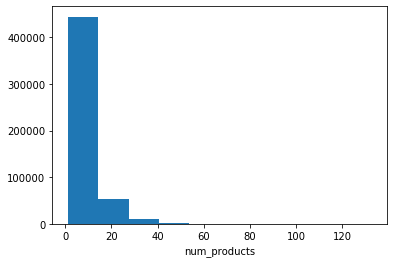

num_weeks


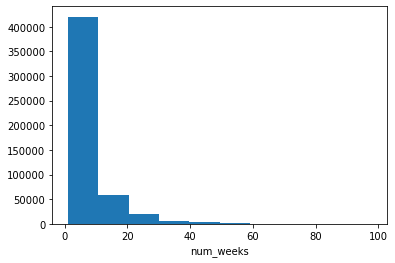

max_week


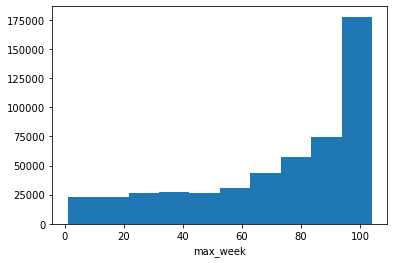

num_visits


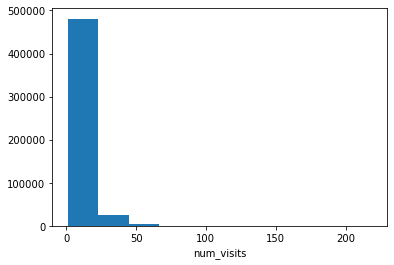

total_coupons


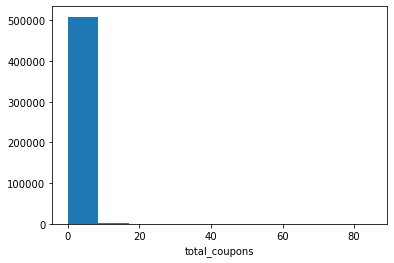

coupon_pct


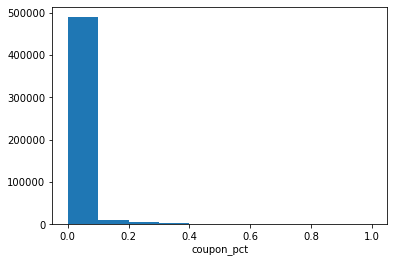

num_commodity


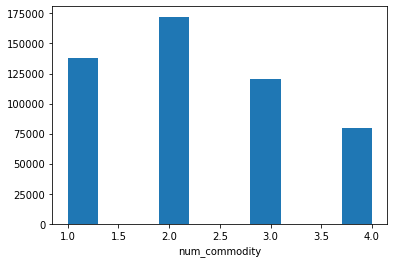

fave_commodity


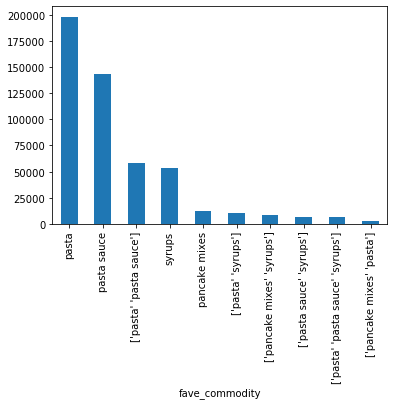

num_brand


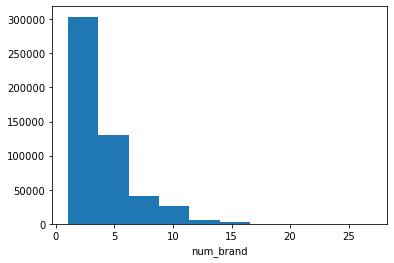

fave_brand


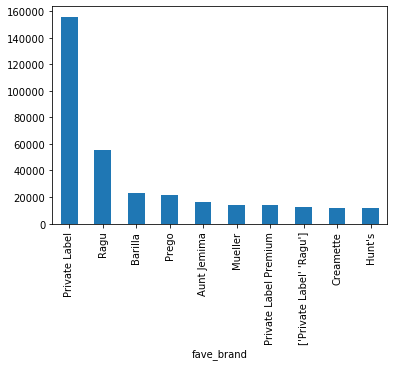

num_stores


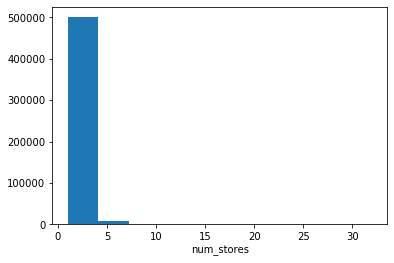

fave_store


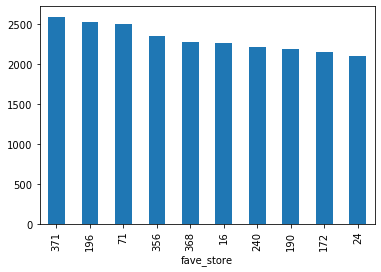

last_trnx


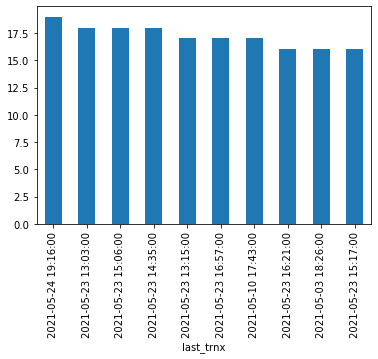

sweet_savoury_mix


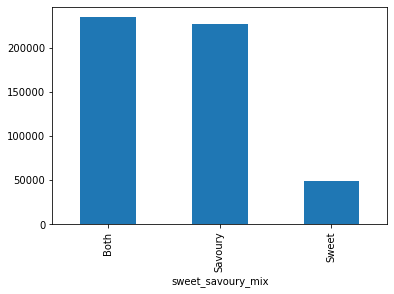

total_sales_y2


c:\users\adam_\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\adam_\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


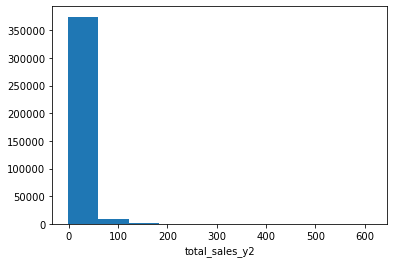

total_units_y2


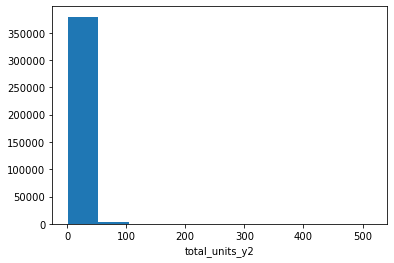

num_weeks_y2


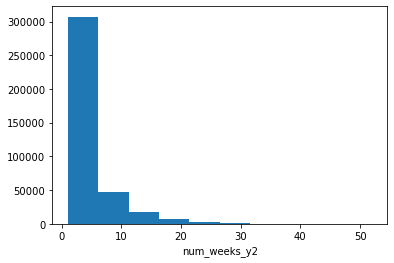

num_visits_y2


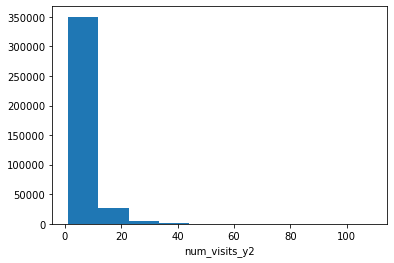

purchase_segment


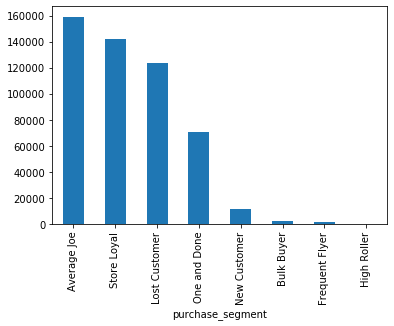

product_segment


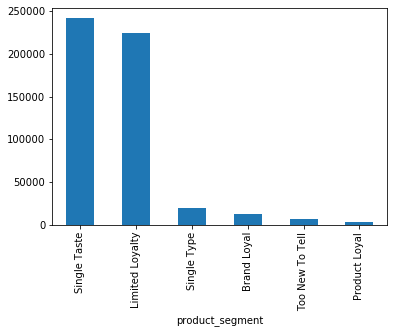

recency


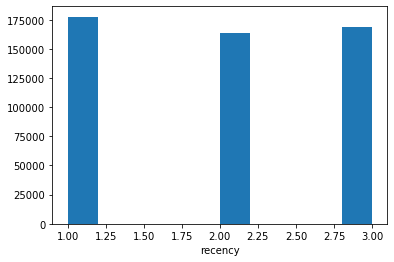

frequency


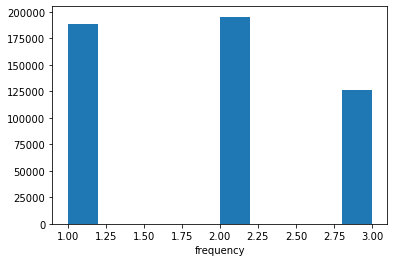

monetary


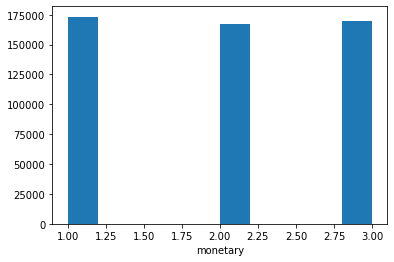

In [61]:
# Plot columns for inspection

for col in customer_profile.columns:
    print(col)
    if customer_profile[col].dtype != "object":
        plt.hist(customer_profile[col])
        plt.xlabel(col)
        plt.show()
    else:
        customer_profile[col].value_counts()[:10].plot(kind="bar")
        plt.xlabel(col)
        plt.show()

In [22]:
# Does the merchandising work?

# Check if being On Feature makes a difference

## Construct On Feature & On Display variables
denorm_trnx["OnFeature"] = denorm_trnx["feature_desc"].apply(lambda x: 0 if x == "Not on Feature" else 1)
denorm_trnx["OnDisplay"] = denorm_trnx["display_desc"].apply(lambda x: 0 if x == "Not on Display" else 1)

## Pivot Data to get a product level view of Units per Store per Week vs OnFeature/NotOnFeature
tmp = denorm_trnx[denorm_trnx["OnDisplay"] == 0].groupby(["Upc","OnFeature"]).agg({"Units":"sum", "Store": "nunique", "Week":"nunique"}).reset_index()
tmp["avg_units"] = tmp.apply(lambda row: (row["Units"] / (row["Store"]*row["Week"])), axis= 1)
tmp_pivot = tmp.pivot(index="Upc", columns="OnFeature", values="avg_units")

## Only 289 Products have been OnFeature
tmp_pivot = tmp_pivot.dropna()

## Use  Paired T-Test to compare
print("T-Test Result for On Feature vs Not On Feature")
print(ttest_rel(tmp_pivot[0], tmp_pivot[1]))

# Check if being On Display makes a difference

## Pivot Data to get a product level view of Units per Store per Week vs OnFeature/NotOnFeature
tmp = denorm_trnx[denorm_trnx["OnFeature"] == 0].groupby(["Upc","OnDisplay"]).agg({"Units":"sum", "Store": "nunique", "Week":"nunique"}).reset_index()
tmp["avg_units"] = tmp.apply(lambda row: (row["Units"] / (row["Store"]*row["Week"])), axis= 1)
tmp_pivot = tmp.pivot(index="Upc", columns="OnDisplay", values="avg_units")

## Only 289 Products have been OnFeature
tmp_pivot = tmp_pivot.dropna()

## Use Paired T-Test to compare
print("T-Test Result for On Display vs Not On Display")
print(ttest_rel(tmp_pivot[0], tmp_pivot[1]))

# Check if being On Display makes a difference (while controlling for price)

## Pivot Data to get a product level view of Units per Store per Week vs OnFeature/NotOnFeature
tmp = denorm_trnx[denorm_trnx["OnDisplay"] == 0].groupby(["Upc","OnFeature"]).agg({"Units":"sum", "Store": "nunique", "Week":"nunique", "sales": "sum", "price": "mean"}).reset_index()
tmp["avg_units"] = tmp.apply(lambda row: (row["Units"] / (row["Store"]*row["Week"])), axis= 1)
tmp_pivot = tmp.pivot(index="Upc", columns="OnFeature", values="avg_units")

## Only 289 Products have been OnFeature
tmp_pivot = tmp_pivot.dropna()

ols_df = tmp.merge(tmp_pivot.reset_index(), left_on="Upc", right_on="Upc", how="inner")

model = OLS(ols_df["avg_units"], ols_df[["OnFeature", "price"]])
fit_model = model.fit()

print(fit_model.summary())

# Check if being On Display makes a difference (while controlling for price)

## Pivot Data to get a product level view of Units per Store per Week vs OnFeature/NotOnFeature
tmp = denorm_trnx[denorm_trnx["OnFeature"] == 0].groupby(["Upc","OnDisplay"]).agg({"Units":"sum", "Store": "nunique", "Week":"nunique", "sales": "sum", "price": "mean"}).reset_index()
tmp["avg_units"] = tmp.apply(lambda row: (row["Units"] / (row["Store"]*row["Week"])), axis= 1)
tmp_pivot = tmp.pivot(index="Upc", columns="OnDisplay", values="avg_units")

## Only 289 Products have been OnFeature
tmp_pivot = tmp_pivot.dropna()

ols_df = tmp.merge(tmp_pivot.reset_index(), left_on="Upc", right_on="Upc", how="inner")

model = OLS(ols_df["avg_units"], ols_df[["OnDisplay", "price"]])
fit_model = model.fit()

print(fit_model.summary())

T-Test Result for On Feature vs Not On Feature
Ttest_relResult(statistic=-14.642061407837312, pvalue=1.1413447466269751e-36)
T-Test Result for On Display vs Not On Display
Ttest_relResult(statistic=-5.374003665117083, pvalue=1.3174550891202127e-07)
                                 OLS Regression Results                                
Dep. Variable:              avg_units   R-squared (uncentered):                   0.588
Model:                            OLS   Adj. R-squared (uncentered):              0.587
Method:                 Least Squares   F-statistic:                              411.5
Date:                Tue, 13 Jul 2021   Prob (F-statistic):                   9.95e-112
Time:                        18:50:58   Log-Likelihood:                         -570.95
No. Observations:                 578   AIC:                                      1146.
Df Residuals:                     576   BIC:                                      1155.
Df Model:                           2          